In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from collections import Counter
import numpy as np
from numpy import loadtxt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

In [ ]:
f = h5py.File('mouse1sample1.hdf5','r')
p_scores = pd.read_csv('merfish_M1S1_filtered_periph_scores.csv')
p_scores = p_scores.loc[p_scores['annotation'] != 'unannotated']

In [ ]:
# # time intensive step: get list of annotated cell_ids and annotation types 
annotated_cells = []
annotations = []
for cell_id in f['cells']:
    cell = f['cells'][cell_id]
    ann = dict(cell.attrs)['annotation']
    if ann != 'unannotated' and cell_id in list(p_scores['cell_id']):
        annotated_cells.append(cell_id)
        annotations.append(ann)
        
annotations_count = Counter(annotations)
print("Number of Annotated Samples:", len(annotated_cells))
print("Num of Cell Types:", len(annotations_count))
print("Max Number of Samples per Cell Type:", max(annotations_count.values()))
print("Min Number of Samples per Cell Type:", min(annotations_count.values()))
print("Average Number of Samples per Cell Type:", sum(annotations_count.values())/93)

In [2]:
periphery data: shape (len(annotated_cells), num_genes)
num_genes = (p_scores['gene']).unique().shape[0]
cell_indices = {k: v for v, k in enumerate(list(p_scores['cell_id'].unique()))}
gene_indices = {k: v for v, k in enumerate(list(p_scores['gene'].unique()))}

periphery_data = np.zeros((len(annotated_cells), num_genes))
for cell_id in annotated_cells:
    subset = p_scores.loc[p_scores['cell_id'] == cell_id]
    for index, s in subset.iterrows():
        cell_index = cell_indices[cell_id]
        gene_index = gene_indices[s['gene']]
        periphery_data[cell_index][gene_index] = s['periphery_score']

# remove outlier genes
expr = np.sum(np.square(periphery_data), axis=0)
periphery_data = periphery_data[:,np.logical_and(expr >= np.percentile(expr, 1), expr <= np.percentile(expr, 99))]
cv = np.std(periphery_data, axis=0) / np.mean(periphery_data, axis=0)
periphery_data = periphery_data[:,np.logical_and(cv >= np.percentile(cv, 1), cv <= np.percentile(cv, 99))]
np.save('periphery_data', periphery_data)

periphery_data = np.load('periphery_data.npy')

# remove outlier genes
expr = np.sum(np.square(periphery_data), axis=0)
periphery_data = periphery_data[:,np.logical_and(expr >= np.percentile(expr, 1), expr <= np.percentile(expr, 99))]
cv = np.std(periphery_data, axis=0) / np.mean(periphery_data, axis=0)
periphery_data = periphery_data[:,np.logical_and(cv >= np.percentile(cv, 1), cv <= np.percentile(cv, 99))]


In [4]:
# #image data: shape (len(annotated_cells), 224, 224))
image_data = np.zeros(shape=(len(annotated_cells), 224, 224)).astype('uint8')
fig = plt.figure(figsize=(4, 4), dpi=56)
plt.gray()
idx = 0
for cell_id in annotated_cells:
    cell = f['cells'][cell_id]
    keys = list(cell['boundaries'].keys())
    midpoint = keys[int(len(keys)/2)]
    boundary = cell['boundaries'][midpoint]
    xs = boundary[:,0]
    ys = boundary[:,1]
    plt.plot(xs,ys)
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    fig.canvas.draw()
    fig_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    fig_array = fig_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    image_data[idx] = fig_array[:,:,0].astype('uint8')
    idx += 1
    plt.clf()
    print(f"\r{idx}", end="")
  
print(image_data.shape)
np.save('image_data', image_data)

image_data = np.load('image_data.npy')
image_data = np.repeat(image_data[..., np.newaxis], 3, -1)

In [5]:
# one hot encoded label vectors
annotation_indices = {k: v for v, k in enumerate(list(annotations_count.keys()))}
labels = np.zeros((len(annotated_cells), len(annotation_indices)))
for index in range(0, len(annotated_cells)):
    cell = f['cells'][annotated_cells[index]]
    ann = dict(cell.attrs)['annotation']
    arr_index = annotation_indices[ann]
    labels[index][arr_index] = 1
print(labels.shape)
np.save('labels', labels)

labels = np.load('labels.npy')
print(labels.shape)

(17312, 80)


In [6]:
indices = [x for x in range(labels.shape[0])]
train_indices, test = train_test_split(indices, test_size=0.3)
test_indices, val_indices = train_test_split(test, test_size=0.5)

image_train, periphery_train, labels_train = image_data[train_indices], periphery_data[train_indices], labels[train_indices]
image_test, periphery_test, labels_test = image_data[test_indices], periphery_data[test_indices], labels[test_indices]
image_val, periphery_val, labels_val = image_data[val_indices], periphery_data[val_indices], labels[val_indices]

print(image_train.shape, periphery_train.shape, labels_train.shape)
print(image_test.shape, periphery_test.shape, labels_test.shape)
print(image_val.shape, periphery_val.shape, labels_val.shape)

(12118, 224, 224, 3) (12118, 184) (12118, 80)
(2597, 224, 224, 3) (2597, 184) (2597, 80)
(2597, 224, 224, 3) (2597, 184) (2597, 80)


In [7]:
# initializing individual models + late fusion model
class WeightedAverage(tf.keras.layers.Layer):

    def __init__(self, n_output):
        super(WeightedAverage, self).__init__()
        self.W = tf.Variable(initial_value=tf.random.uniform(shape=[1,1,n_output], minval=0, maxval=1),
            trainable=True) # (1,1,n_inputs)

    def call(self, inputs):

        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = tf.keras.layers.concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim
        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)
    
periphery_model = tf.keras.models.Sequential([tf.keras.layers.Input(periphery_data.shape[1]),
                                    tf.keras.layers.Dense(100, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(50, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(25, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(80, activation=tf.nn.softmax)])

image_model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),padding='same', activation='relu',input_shape=(224, 224, 3)),
                                    tf.keras.layers.MaxPool2D((2,2)), 
                                    tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dropout(0.9),
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(80, activation=tf.nn.softmax)])

# model = tf.keras.models.Sequential()
# model.add(WeightedAverage(periphery_model.output, image_model.output))
# # weighted_average = tf.keras.layers.concatenate([tf.multiply(periphery_model.output, 0.1), tf.multiply(image_model.output, 0.1)], axis=0)
# # WA = WeightedAverage(n_output = 2)([periphery_model.output, image_model.output])
# # model = tf.keras.models.Model(inputs=[periphery_model.input, image_model.input], outputs = WA)
# model.summary()

2021-12-09 22:32:18.781057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 22:32:18.894667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 22:32:18.895569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 22:32:18.897141: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
# # compiling late fusion model with exponential decay lr
lr= tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True)

# early stopping to prevent overfitting 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
periphery_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', multi_label=True, num_labels=80)])
# image_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [9]:
# late fusion model training
periphery_model.fit(x=periphery_train, y=labels_train, epochs=200, validation_data=(periphery_val, labels_val))

2021-12-09 22:32:21.296303: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
379/379 [==============================] - 4s 6ms/step - loss: 4.3242 - accuracy: 0.0300 - auc: 0.0132 - val_loss: 4.1716 - val_accuracy: 0.0431 - val_auc: 0.0157
Epoch 2/200
379/379 [==============================] - 2s 5ms/step - loss: 3.7468 - accuracy: 0.0977 - auc: 0.0156 - val_loss: 3.5013 - val_accuracy: 0.1201 - val_auc: 0.0189
Epoch 3/200
379/379 [==============================] - 2s 5ms/step - loss: 3.4676 - accuracy: 0.1169 - auc: 0.0221 - val_loss: 3.4404 - val_accuracy: 0.1302 - val_auc: 0.0227
Epoch 4/200
379/379 [==============================] - 2s 5ms/step - loss: 3.4161 - accuracy: 0.1382 - auc: 0.0275 - val_loss: 3.4024 - val_accuracy: 0.1479 - val_auc: 0.0284
Epoch 5/200
379/379 [==============================] - 2s 5ms/step - loss: 3.3660 - accuracy: 0.1813 - auc: 0.0333 - val_loss: 3.3543 - val_accuracy: 0.2029 - val_auc: 0.0342
Epoch 6/200
379/379 [==============================] - 2s 5ms/step - loss: 3.3091 - accuracy: 0.2125 - auc: 0.0382 - val_loss

In [10]:
periphery_model.evaluate(periphery_test, labels_test)

82/82 [==============================] - 0s 3ms/step - loss: 1.9481 - accuracy: 0.4694 - auc: 0.1488


[1.948124647140503, 0.4693877696990967, 0.14883194863796234]

In [11]:
image_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy', tf.keras.metrics.AUC(curve='PR')])

In [12]:
# late fusion model training
image_model.fit(x=image_train, y=labels_train, epochs=10, validation_data=(image_val, labels_val))

2021-12-09 22:38:20.758955: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1824098304 exceeds 10% of free system memory.
2021-12-09 22:38:21.747708: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1824098304 exceeds 10% of free system memory.


Epoch 1/10


2021-12-09 22:38:23.870954: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


379/379 [==============================] - 34s 62ms/step - loss: 8.6119 - accuracy: 0.0853 - auc_1: 0.0125 - val_loss: 4.3529 - val_accuracy: 0.1201 - val_auc_1: 0.0125
Epoch 2/10
379/379 [==============================] - 22s 59ms/step - loss: 4.3385 - accuracy: 0.1095 - auc_1: 0.0125 - val_loss: 4.3236 - val_accuracy: 0.1201 - val_auc_1: 0.0125
Epoch 3/10
379/379 [==============================] - 22s 58ms/step - loss: 4.3098 - accuracy: 0.1146 - auc_1: 0.0125 - val_loss: 4.2955 - val_accuracy: 0.1201 - val_auc_1: 0.0125
Epoch 4/10
379/379 [==============================] - 22s 59ms/step - loss: 4.2828 - accuracy: 0.1146 - auc_1: 0.0125 - val_loss: 4.2691 - val_accuracy: 0.1201 - val_auc_1: 0.0125
Epoch 5/10
379/379 [==============================] - 22s 58ms/step - loss: 4.2567 - accuracy: 0.1146 - auc_1: 0.0351 - val_loss: 4.2431 - val_accuracy: 0.1201 - val_auc_1: 0.0449
Epoch 6/10
379/379 [==============================] - 22s 59ms/step - loss: 4.1417 - accuracy: 0.1146 - auc_1: 

In [13]:
# evaluation 
image_prediction = image_model.predict(image_test)
periphery_prediction = periphery_model.predict(periphery_test)
late_fusion_prediction = 0.999*periphery_prediction + 0.001*image_prediction

In [14]:
image_model.evaluate(image_test, labels_test)

82/82 [==============================] - 1s 16ms/step - loss: 4.1260 - accuracy: 0.1336 - auc_1: 0.0385


[4.125993251800537, 0.13361571729183197, 0.03847469761967659]

In [15]:
y_pred=np.argmax(late_fusion_prediction, axis=1)
y_test=np.argmax(labels_test, axis=1)

In [16]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.13059860396199002

In [17]:
accuracy_score(y_test, y_pred)

0.46938775510204084

In [18]:
print("image_model accuracies")
print(accuracy_score(y_test, np.argmax(image_prediction, axis=1)))
print(balanced_accuracy_score(y_test, np.argmax(image_prediction, axis=1)))

image_model accuracies
0.13361571043511744
0.01282051282051282


In [19]:
print("periphery_model accuracies")
print(accuracy_score(y_test, np.argmax(periphery_prediction, axis=1)))
print(balanced_accuracy_score(y_test, np.argmax(periphery_prediction, axis=1)))

periphery_model accuracies
0.46938775510204084
0.13059860396199002


In [20]:
count_arr = np.bincount(y_test)

In [22]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
count_arr = np.bincount(y_test)
report = classification_report(y_test, y_pred, output_dict=True)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
f1_scores = []
for i in range(0, 80):
    if str(i) in report:
        f1_scores.append(report[str(i)]['f1-score'])
    else:
        f1_scores.append(0.0)

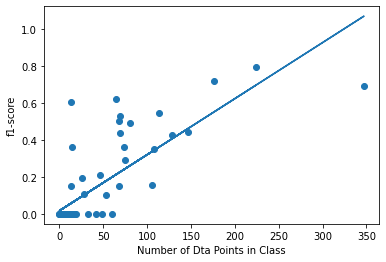

In [24]:
plt.scatter(count_arr, f1_scores)
plt.xlabel('Number of Dta Points in Class')
plt.ylabel('f1-score')
m, b = np.polyfit(count_arr, f1_scores, 1)
plt.plot(count_arr, m*count_arr + b)